# Improving Random Input Sample Explanation (RISE) with Statistical Fault Localisation techniques

In [13]:
import os
import shutil
import filecmp
import math


## Define necesary libraries

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms.functional import resize, InterpolationMode
from ipywidgets import interact, IntSlider, fixed
from tensorflow.keras.applications.resnet50 import preprocess_input
from IPython.display import display
from PIL import Image
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
import shap
import json
from torch.nn.functional import softmax, conv2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [15]:
cudnn.benchmark = True
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()
for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)

c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
from utils import *
img_path = 'catdog.png'
img = read_tensor(img_path)

with torch.no_grad():
    output = model(img)
    top_probabilities, top_classes = torch.topk(output, k=3, dim=1)
    top_pred_class = top_classes[0][0].item()
    top_pred_class_name = get_class_name(top_pred_class)

for zx in range(3):
    class_name = get_class_name(top_classes[0][zx].item())
    percentage = top_probabilities[0][zx].item() * 100
    print(f'Top {zx+1} class: {class_name}, Probability: {percentage:.2f}%')

Top 1 class: bull mastiff, Probability: 38.42%
Top 2 class: tiger cat, Probability: 16.85%
Top 3 class: boxer, Probability: 9.39%


In [17]:
target_class = top_pred_class
class SFL:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = torch.tensor(input_size, device='cuda')
        self.device = torch.device('cuda')

    def generate_support_masks(self, N, s, p1, input_size=(224, 224)):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Calculate cell size and up size
        cell_size = torch.ceil(torch.tensor(self.input_size).float() / s)
        up_size = ((s + 1) * cell_size).int()

        # Create random grid
        grid = (torch.rand(N, s, s) < p1).float().to(self.device)

        # Initialize support masks
        support_masks = torch.empty(N, 1, *input_size, device=self.device)

        for i in range(N):
            # Random shifts
            x = torch.randint(0, int(cell_size[0]), (1,))
            y = torch.randint(0, int(cell_size[1]), (1,))

            # Resize grid
            resized_grid = resize(grid[i].unsqueeze(0), tuple(up_size.int().tolist()), 
                                  interpolation=InterpolationMode.BILINEAR)

            # Crop and assign to support masks
            support_masks[i, 0] = resized_grid[0, 
                                               x:x + input_size[0], 
                                               y:y + input_size[1]]
        return support_masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]
    
    @torch.no_grad()
    def generate_mutants_batch(self, img_tensor, N, s, p1, target_class, batch_size=50):
    
        _, channels, height, width = img_tensor.shape
        self.masks = torch.empty((N, 1, height, width), device=self.device)
        sampled_tensor = torch.empty((N, channels, height, width), device=self.device)
        confidence_scores = []
        
        for start_idx in tqdm(range(0, N, batch_size), total=(N + batch_size - 1) // batch_size, ascii="░▒█"):
            end_idx = min(start_idx + batch_size, N)
            batch_size_current = end_idx - start_idx
            
            batch_masks = torch.empty((batch_size_current, 1, height, width), device=self.device)
            found_flags = torch.zeros(batch_size_current, dtype=torch.bool, device=self.device)
            
            while not found_flags.all():
                # Generate masks for all unfound samples in the batch
                unfound_indices = torch.where(~found_flags)[0]
                pass_indices = unfound_indices[unfound_indices % 2 == 0]
                fail_indices = unfound_indices[unfound_indices % 2 == 1]
                
                if len(pass_indices) > 0:
                    batch_masks[pass_indices] = self.generate_support_masks(len(pass_indices), s, 0.2, input_size=(height, width))
                if len(fail_indices) > 0:
                    batch_masks[fail_indices] = self.generate_support_masks(len(fail_indices), s, 0.8, input_size=(height, width))
                
                # Apply masks to all images in the batch simultaneously
                masked_images = torch.mul(batch_masks, img_tensor.expand(batch_size_current, -1, -1, -1))
                
                outputs = self.model(masked_images)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                
                target_class_probs = probabilities[:, target_class]

                top_classes = outputs.argmax(dim=1)
     
            
                confidence_scores.extend(target_class_probs.tolist())
                
                # Check conditions for all samples in the batch
                pass_condition = (top_classes == target_class) & (~found_flags) & (torch.arange(batch_size_current, device=self.device) % 2 == 0)
                fail_condition = (top_classes != target_class) & (~found_flags) & (torch.arange(batch_size_current, device=self.device) % 2 == 1)
                
                new_found = pass_condition | fail_condition
                found_flags |= new_found
                
                # Update masks and sampled tensor for newly found samples
                found_indices = start_idx + torch.where(new_found)[0]
                self.masks[found_indices] = batch_masks[new_found].clone().detach().requires_grad_(False)
                sampled_tensor[found_indices] = masked_images[new_found].clone().detach().requires_grad_(False)
        
        return self.masks, sampled_tensor, confidence_scores


explainer = SFL(model, (224, 224))

N = 100
s = 8
p1 = 0.2
masks, sampled_tensor, confidence_scores = explainer.generate_mutants_batch(img.cuda(), N, s, p1, target_class=target_class)

  0%|░░░░░░░░░░| 0/2 [00:00<?, ?it/s]C:\Users\eagua\AppData\Local\Temp\ipykernel_57828\3006701724.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cell_size = torch.ceil(torch.tensor(self.input_size).float() / s)
100%|██████████| 2/2 [00:10<00:00,  5.22s/it]


In [18]:
with torch.no_grad():
    output = model(sampled_tensor)
    top_probabilities, top_classes = torch.topk(output, k=3, dim=1)
    top_pred_class = top_classes[0][0].item()

for zx in range(3):
    class_name = top_classes[0][zx].item()
    percentage = top_probabilities[0][zx].item() * 100
    print(f'Top {zx+1} class: {class_name}, Probability: {percentage:.2f}%')

confidence_scores = []
for ss in range(N):
    score = top_probabilities[ss][0].item() * 100
    confidence_scores.append(score)


Top 1 class: 243, Probability: 48.12%
Top 2 class: 254, Probability: 20.42%
Top 3 class: 245, Probability: 17.91%


In [19]:
def generate_pass_fail_list(N):
    return ["Pass" if i % 2 == 0 else "Fail" for i in range(N)]

pass_fail_list = generate_pass_fail_list(N)

Iteractive widget for visualizing all mutants created 



In [20]:
#Creating a visualisation for every single mutant, the mask won't look black anymore because is been denormalised for visualisation purposes.
def visualize_single_mutant(mutants, pass_fail_list, index):
    mutant_image = mutants[index].detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Squeeze and permute dimensions
    plt.figure(figsize=(5, 5))
    plt.imshow(mutant_image)
    plt.title(f"Mutant {index+1}\n{pass_fail_list[index]}")
    plt.axis('off')
    plt.show()
    
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(sampled_tensor.device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(sampled_tensor.device)
mutants_denorm = sampled_tensor * std + mean

num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant,
         mutants=fixed(mutants_denorm),
         pass_fail_list=fixed(pass_fail_list),
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

savepath = 'mask.npy'
mask_array = masks.detach().cpu().numpy()
np.save(savepath, mask_array)

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=99), Output()), _dom_classes=('widge…

In [21]:
# Function to visualize a single mask
def visualize_single_mask(masks, pass_fail_list, index):
    mask_image = masks[index].detach().squeeze(0).cpu().numpy()  # Squeeze the channel dimension to get [224, 224]
    plt.figure(figsize=(5, 5))
    plt.imshow(mask_image, cmap='gray')  # Visualize in grayscale
    plt.title(f"Mask {index+1}\n{pass_fail_list[index]}")
    plt.axis('off')
    plt.show()


# Number of masks
num_masks = masks.shape[0]

# Interactive widget to visualize masks
interact(visualize_single_mask,
         masks=fixed(masks),
         pass_fail_list=fixed(pass_fail_list),
         index=IntSlider(min=0, max=num_masks-1, step=1, description='Mask Index:'));


interactive(children=(IntSlider(value=0, description='Mask Index:', max=99), Output()), _dom_classes=('widget-…

In [22]:
def calculate_relevance_scores(sampled_tensor, mask, N, confidence_scores, device='cuda'):
    sampled_tensor = sampled_tensor.to(device)
   
    _, C, H, W = sampled_tensor.shape
    # Create indices for pass and fail cases
    all_indices = torch.arange(N, device=device)
    if N % 2 == 0:
        # For even N, even indices are pass, odd indices are fail
        pass_indices = all_indices[all_indices % 2 == 0]
        fail_indices = all_indices[all_indices % 2 != 0]
    else:
        # For odd N, odd indices are pass, even indices are fail
        pass_indices = all_indices[all_indices % 2 != 0]
        fail_indices = all_indices[all_indices % 2 == 0]

    
    confidence_scores = np.array(confidence_scores)
    
    good_scores = confidence_scores[::2]  # Every 2nd element, starting from index 0
    fail_scores = confidence_scores[1::2]


    good_scores = torch.tensor(good_scores, dtype=torch.float32, device=device)
    fail_scores = torch.tensor(fail_scores, dtype=torch.float32, device=device)
    m = math.ceil(N/2)

    goodscalar = good_scores.view(m, 1, 1, 1)
    badscalar = good_scores.view(m, 1, 1, 1)

    shape = (N, 1, H, W)
    tensor_ones = torch.ones(shape).to(device)
    
    executed_tensors = mask
    not_executed_tensors = torch.sub(tensor_ones, mask)
    
    '''
    e_pass_tensors = torch.mul(executed_tensors[pass_indices], goodscalar)
    e_fail_tensors = torch.mul(executed_tensors[fail_indices], badscalar)
    n_pass_tensors = torch.mul(not_executed_tensors[pass_indices], goodscalar)
    n_fail_tensors = torch.mul(not_executed_tensors[fail_indices], badscalar)
    '''
    e_pass_tensors = executed_tensors[pass_indices]
    e_fail_tensors =  executed_tensors[fail_indices]
    n_pass_tensors = not_executed_tensors[pass_indices]
    n_fail_tensors = not_executed_tensors[fail_indices]
    Ep = e_pass_tensors.sum(dim=0) 
    Ef = e_fail_tensors.sum(dim=0) 
    Np = n_pass_tensors.sum(dim=0) 
    Nf = n_fail_tensors.sum(dim=0) 
    return Ep, Ef, Np, Nf

def calculate_ochiai(Ep, Np, Ef, Nf):
    numerator = Ef
    denominator = torch.sqrt(torch.mul(torch.add(Ef, Nf), torch.add(Ef, Ep)))
    return torch.div(numerator, denominator)

def calculate_tarantula(Ep, Np, Ef, Nf):
    numerator = torch.div(Ef, Ef + Nf)
    denominator = numerator + torch.div(Ep, Ep + Np)
    return torch.div(numerator, denominator)

def calculate_zoltar(Ep, Np, Ef, Nf):
    return torch.div(Ef, Ef + Nf + Ep + torch.div(10000 * Nf * Ep, Ef))

def calculate_wong1(Ep, Np, Ef, Nf):
    return Ef - Ep

def calculate_all_scores(img, masks, N):
    Ep, Ef, Np, Nf = calculate_relevance_scores(img, masks, N,confidence_scores)
    
    ochiai_scores = calculate_ochiai(Ep, Np, Ef, Nf)
    tarantula_scores = calculate_tarantula(Ep, Np, Ef, Nf)
    zoltar_scores = calculate_zoltar(Ep, Np, Ef, Nf)
    wong1_scores = calculate_wong1(Ep, Np, Ef, Nf)
    
    #Original Fault Localization are supposed to find the bad pixels, in order to find relevants let's inverse values
    ochiai_array = ochiai_scores.detach().cpu().numpy().max() - ochiai_scores.detach().cpu().numpy()
    tarantula_array = tarantula_scores.detach().cpu().numpy().max() - tarantula_scores.detach().cpu().numpy()
    zoltar_array = zoltar_scores.detach().cpu().numpy().max() -zoltar_scores.detach().cpu().numpy()
    wong1_array = wong1_scores.detach().cpu().numpy().max() - wong1_scores.detach().cpu().numpy()
    
    scores_dict = {
        'Ep': Ep,
        'Ef': Ef,
        'Np': Np,
        'Nf': Nf,
        'ochiai': ochiai_scores,
        'tarantula': tarantula_scores,
        'zoltar': zoltar_scores,
        'wong1': wong1_scores
    }
    
    return scores_dict, ochiai_array, tarantula_array, zoltar_array, wong1_array

pixel_scores, ochiai_array, tarantula_array, zoltar_array, wong1_array = calculate_all_scores(img, masks, N)


# Create a dataset with each pixel's scores
H, W = img.shape[-2:]
dataset = []
for i in range(H):
    for j in range(W):
        pixel_data = {
            'position': (i, j),
            'Ep': pixel_scores['Ep'][0, i, j].item(),
            'Ef': pixel_scores['Ef'][0, i, j].item(),
            'Np': pixel_scores['Np'][0, i, j].item(),
            'Nf': pixel_scores['Nf'][0, i, j].item(),
            'ochiai': pixel_scores['ochiai'][0, i, j].item(),
            'tarantula': pixel_scores['tarantula'][0, i, j].item(),
            'zoltar': pixel_scores['zoltar'][0, i, j].item(),
            'wong1': pixel_scores['wong1'][0, i, j].item()
        }
        dataset.append(pixel_data)

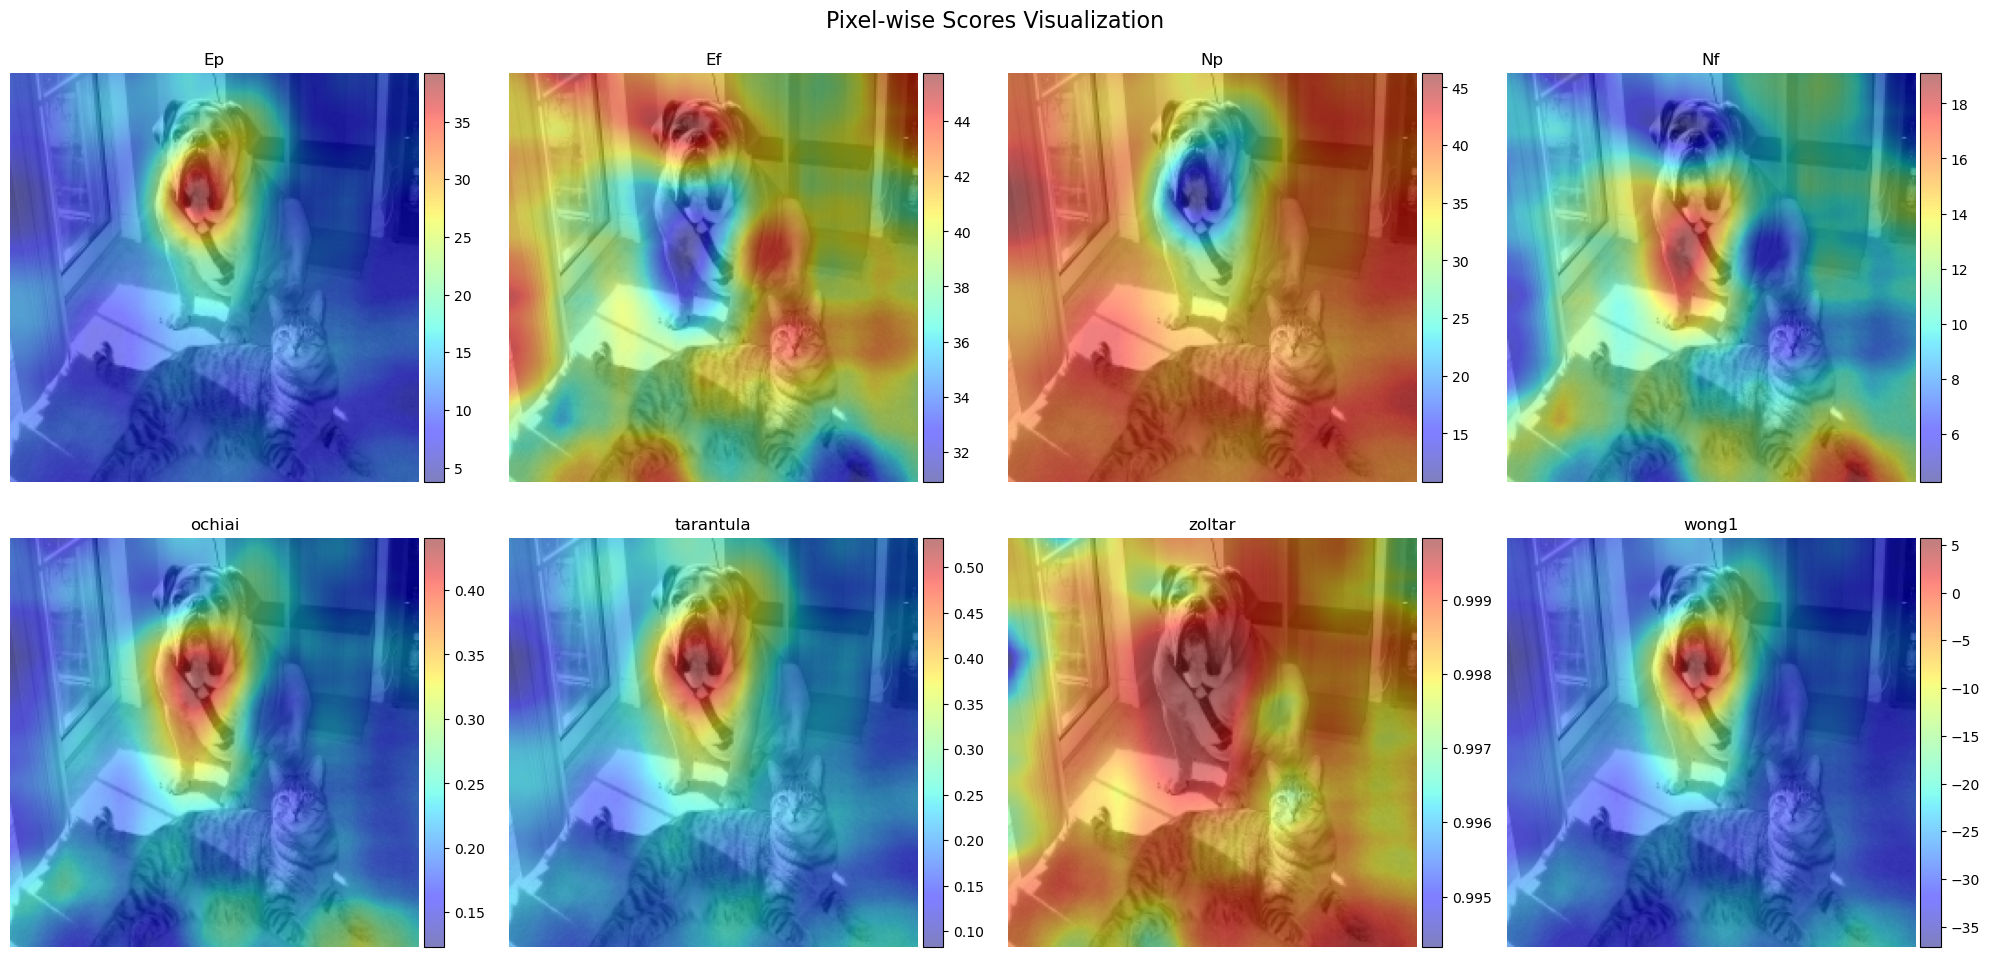

In [23]:
def visualize_pixel_scores(dataset, image_shape, original_image_array):
    # Extract scores and reshape them into 2D arrays
    scores = {
        'Ep': np.zeros(image_shape),
        'Ef': np.zeros(image_shape),
        'Np': np.zeros(image_shape),
        'Nf': np.zeros(image_shape),
        'ochiai': np.zeros(image_shape),
        'tarantula': np.zeros(image_shape),
        'zoltar': np.zeros(image_shape),
        'wong1': np.zeros(image_shape)
    }
    for pixel in dataset:
        i, j = pixel['position']
        for score_type in scores.keys():
            scores[score_type][i, j] = pixel[score_type]
    
    # Invert values for ochiai and tarantula
    scores['ochiai'] = 1 - scores['ochiai']
    scores['tarantula'] = 1 - scores['tarantula']
    scores['zoltar']  = 1 - scores['zoltar']
    scores['wong1']  = 1 - scores['wong1']
    
    # Set up the plot
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle("Pixel-wise Scores Visualization", fontsize=16)
    # Define a color map
    cmap = plt.get_cmap('jet')
    # Plot each score type
    for idx, (score_type, score_data) in enumerate(scores.items()):
        row = idx // 4
        col = idx % 4
        ax = axs[row, col]
        
        # Create the heatmap
        im = ax.imshow(original_image_array, cmap='gray', alpha=1)
        im = ax.imshow(score_data, cmap=cmap, alpha=0.5)
        ax.set_title(score_type)
        ax.axis('off')
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Load and resize the original image, and convert to grayscale

original_image = Image.open(img_path).resize((224, 224)).convert('L')
original_image_array = np.array(original_image)

visualize_pixel_scores(dataset, (224, 224), original_image_array)

# Comparison with original method + alternative design

The original RISE utilizes Monte Carlo sampling to create a random set of binary mask, multiplying the image to create a tensor of mutant images. I attempted to upgrade this algorith further by using adapting Fault Localization techniques to Causal Inference. For it, it was neccesary to use the optimal balanced set of mask (50% fail, 50% pass).

This change not only improve the original algorithm, but I proved that even by only using that *balance set*, we can still improve this algorithm by using the original pixel relevance method from RISE. 

## Alternative Design: Balance Set + Original Pixel Relevance method from RISE.

In [24]:
from evaluation import CausalMetric, auc, gkern
from explanations import RISE
from torch.nn.functional import conv2d

klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

explainer = RISE(model, (224, 224))
explainer.load_masks('mask.npy',p1,s)

sal = explainer(img.cuda())[target_class].cpu().numpy()

plt.axis('off')
plt.title(get_class_name(target_class))
tensor_imshow(img[0].cpu())
plt.imshow(sal, cmap='jet', alpha=0.5)
plt.show()

model = model.eval()
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

# Get the max value
max_value = np.max(sal)
mean_value = np.mean(sal)
min_value = np.min(sal)
print("Max value:", max_value)
print("Mean value:", mean_value)
print("Mix value:", min_value)

Sparsity = max_value/mean_value #Before normalization

Snorm = (sal - min_value )/(max_value - min_value)
Smean = 1/np.mean(Snorm)
print(Smean)

hd = deletion.single_run(img, sal, verbose=1)
hi = insertion.single_run(img, sal, verbose=1)

sc3d = auc(hd)
sc3i = auc(hi)

print(f"AUC - Deletion:{sc3d:.2}")
print(f"AUC - Deletion:{sc3i:.2}")

TypeError: expected str, bytes or os.PathLike object, not int

# Original Random Input Sample Explanations

Generating filters: 100%|██████████| 100/100 [00:00<00:00, 492.41it/s]


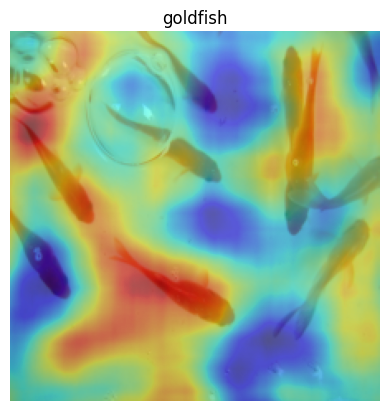

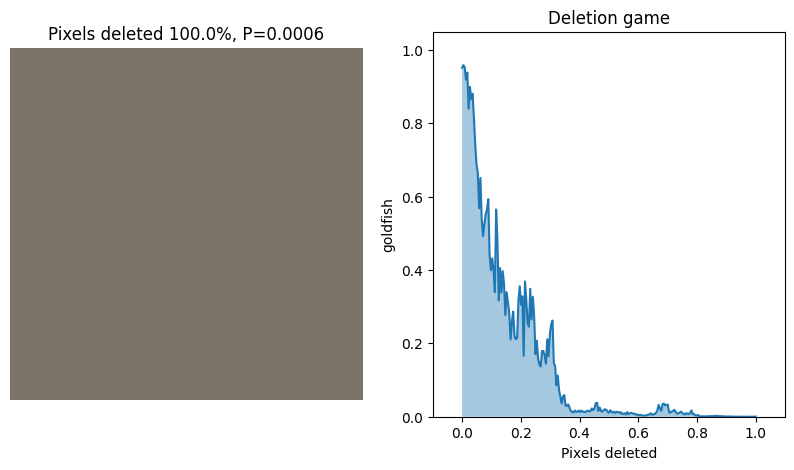

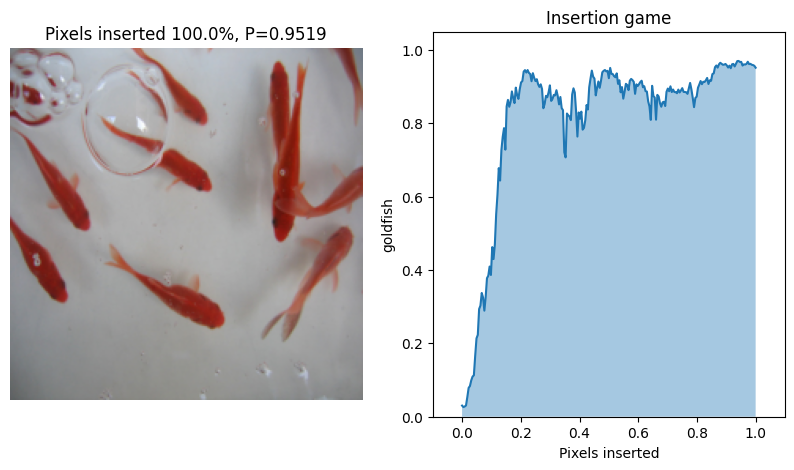

AUC - Deletion:0.14
AUC - Deletion:0.82


In [ ]:
explainer.generate_masks(N, s, p1, savepath='masks.npy') 
explainer.load_masks('masks.npy',p1,s)

sal_og = explainer(img.cuda())[target_class].cpu().numpy()
img = read_tensor(img_path)
tensor_imshow(img[0])
plt.axis('off')
plt.title(get_class_name(target_class))
plt.imshow(sal_og, cmap='jet', alpha=0.5)
plt.show()

hd = deletion.single_run(img, sal_og, verbose=1)
hi = insertion.single_run(img, sal_og, verbose=1)
# Get the max value
max_value = np.max(sal_og)
mean_value = np.mean(sal_og)
min_value = np.min(sal_og)

Sparsity = max_value/mean_value #Before normalization

Snorm = (sal_og - min_value )/(max_value - min_value)
Smean = 1/np.mean(Snorm)
sc3d = auc(hd)
sc3i = auc(hi)

print(f"AUC - Deletion:{sc3d:.2}")
print(f"AUC - Deletion:{sc3i:.2}")

In [ ]:
from tabulate import tabulate  
from saliency_maps_metrics.saliency_maps_metrics.multi_step_metrics import Deletion, Insertion, compute_correlation, compute_auc_metric
from saliency_maps_metrics.saliency_maps_metrics.data_replace import select_data_replace_method

# Function to calculate sparsity
def calculate_sparsity(saliency_map):
    max_value = np.max(saliency_map)
    mean_value = np.mean(saliency_map)
    return max_value / mean_value if mean_value != 0 else float('inf')

# Create a dictionary of saliency maps
saliency_maps = {
    "Original Rise": sal_og,
    "Balanced Rise": sal,
    "Wong1": wong1_array[0],
    "Tarantula": tarantula_array[0],
    "Zoltar": zoltar_array[0],
    "Ochiai": ochiai_array[0]
}

device='cuda'
# Create instances of Deletion and Insertion metrics
deletion_metric = Deletion(data_replace_method="black", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)
insertion_metric = Insertion(data_replace_method="blur", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)

# Initialize lists to store results
results = []

# Loop through each saliency map
for name, saliency_map in saliency_maps.items():
    # Convert saliency map to PyTorch tensor and add batch and channel dimensions
    saliency_map_tensor = torch.from_numpy(saliency_map).float().unsqueeze(0).unsqueeze(0)
    saliency_map_tensor = saliency_map_tensor.to(device)

    # Compute Deletion metrics
    deletion_result = deletion_metric(model, img, saliency_map_tensor, class_to_explain_list=[target_class])
    dauc_mean = deletion_result["dauc"]
    dc_mean = deletion_result["dc"]

    # Compute Insertion metrics
    insertion_result = insertion_metric(model, img, saliency_map_tensor, class_to_explain_list=[target_class])
    iauc_mean = insertion_result["iauc"]
    ic_mean = insertion_result["ic"]
    
    # Calculate sparsity
    sparsity = calculate_sparsity(saliency_map)
    # Store results
    results.append([name, dauc_mean, dc_mean, iauc_mean, ic_mean, sparsity])

# Create a table using tabulate
headers = ["Saliency Map", "DAUC", "DC", "IAUC", "IC","Sparsity"]
table = tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f")

# Print the table
print(f"Metrics for target class: {target_class}")
print(table)

Metrics for target class: 1
+----------------+--------+--------+--------+---------+------------+
| Saliency Map   |   DAUC |     DC |   IAUC |      IC |   Sparsity |
+================+========+========+========+=========+============+
| Original Rise  | 0.1396 | 0.1454 | 0.3970 | -0.0216 |     1.4576 |
+----------------+--------+--------+--------+---------+------------+
| Balanced Rise  | 0.2079 | 0.1028 | 0.0724 | -0.2718 |     1.2534 |
+----------------+--------+--------+--------+---------+------------+
| Wong1          | 0.0576 | 0.3265 | 0.5626 |  0.0045 |     3.9777 |
+----------------+--------+--------+--------+---------+------------+
| Tarantula      | 0.0790 | 0.3630 | 0.4532 | -0.0219 |     5.0377 |
+----------------+--------+--------+--------+---------+------------+
| Zoltar         | 0.0599 | 0.2465 | 0.5478 |  0.0280 |     1.4628 |
+----------------+--------+--------+--------+---------+------------+
| Ochiai         | 0.0598 | 0.3187 | 0.5515 | -0.0001 |     5.1185 |
+-----